In [1]:
import sys
# Add the src directory to the Python path
sys.path.insert(0, '../src')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from botcoin.profilers.stock import StockProfiler
from botcoin.profilers.portfolio import PortfolioProfiler
from botcoin.utils.visual.statistics import plot_efficient_frontier

In [3]:
profiler = StockProfiler()

In [4]:
symbols = ['BRK-B', 'COIN', 'MCD', 'HPQ', 'MSFT', 'T', 'BTC-USD', 'CSCO', 'XOM', 'LLY', 'AMZN']
holdings = [9, 30, 7, 100, 3, 40, 0.02752634, 0, 0, 0, 0]

pp = PortfolioProfiler(symbols=symbols, holdings=holdings)

print(f"Portfolio Value: ${pp.portfolio_value:.2f}")

2025-07-08 18:34:49,381 - DataManager - WARNING: The start date 2019-07-10 is before the IPO date 2021-04-14 for COIN. Adjusting start date to the IPO date.
2025-07-08 18:34:49,386 - YfDataProvider - WARNING: Negative IPO date milliseconds for MCD, returning the earliest available date.
2025-07-08 18:34:49,807 - YfDataProvider - WARNING: Negative IPO date milliseconds for HPQ, returning the earliest available date.
c:\Users\runfei\projects\Botcoin\notebooks\../src\botcoin\data\historical.py:167: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
2025-07-08 18:34:51,329 - DataManager - INFO: Data saved to data\BTC-USD_ohlcv_1d.parquet
2025-07-08 18:34:51,341 - YfDataProvider - WARNING: Negative IPO date milliseconds for XOM, returning the earliest available date.


Portfolio Value: $25059.90


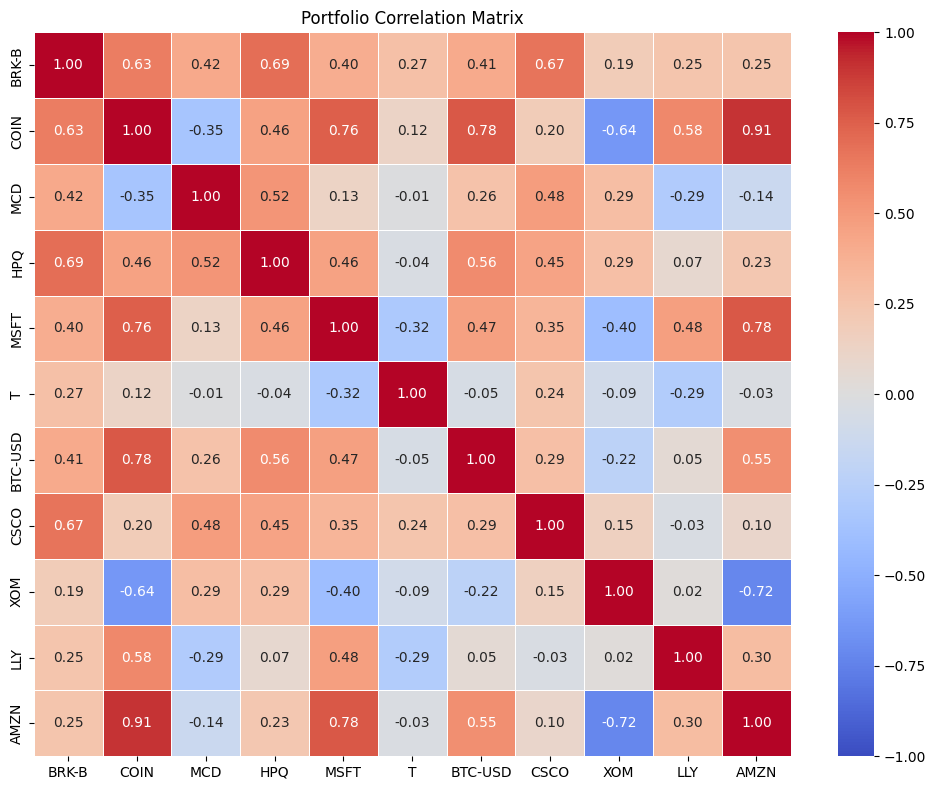

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(pp.compute_cor_matrix(), 
            annot=True,       # Show values in cells
            cmap='coolwarm',  # Color palette
            vmin=-1, vmax=1,  # Set range for correlation values
            linewidths=0.5,   # Grid lines
            fmt=".2f")        # Format numbers to 2 decimals
plt.title("Portfolio Correlation Matrix")
plt.tight_layout()
plt.show()


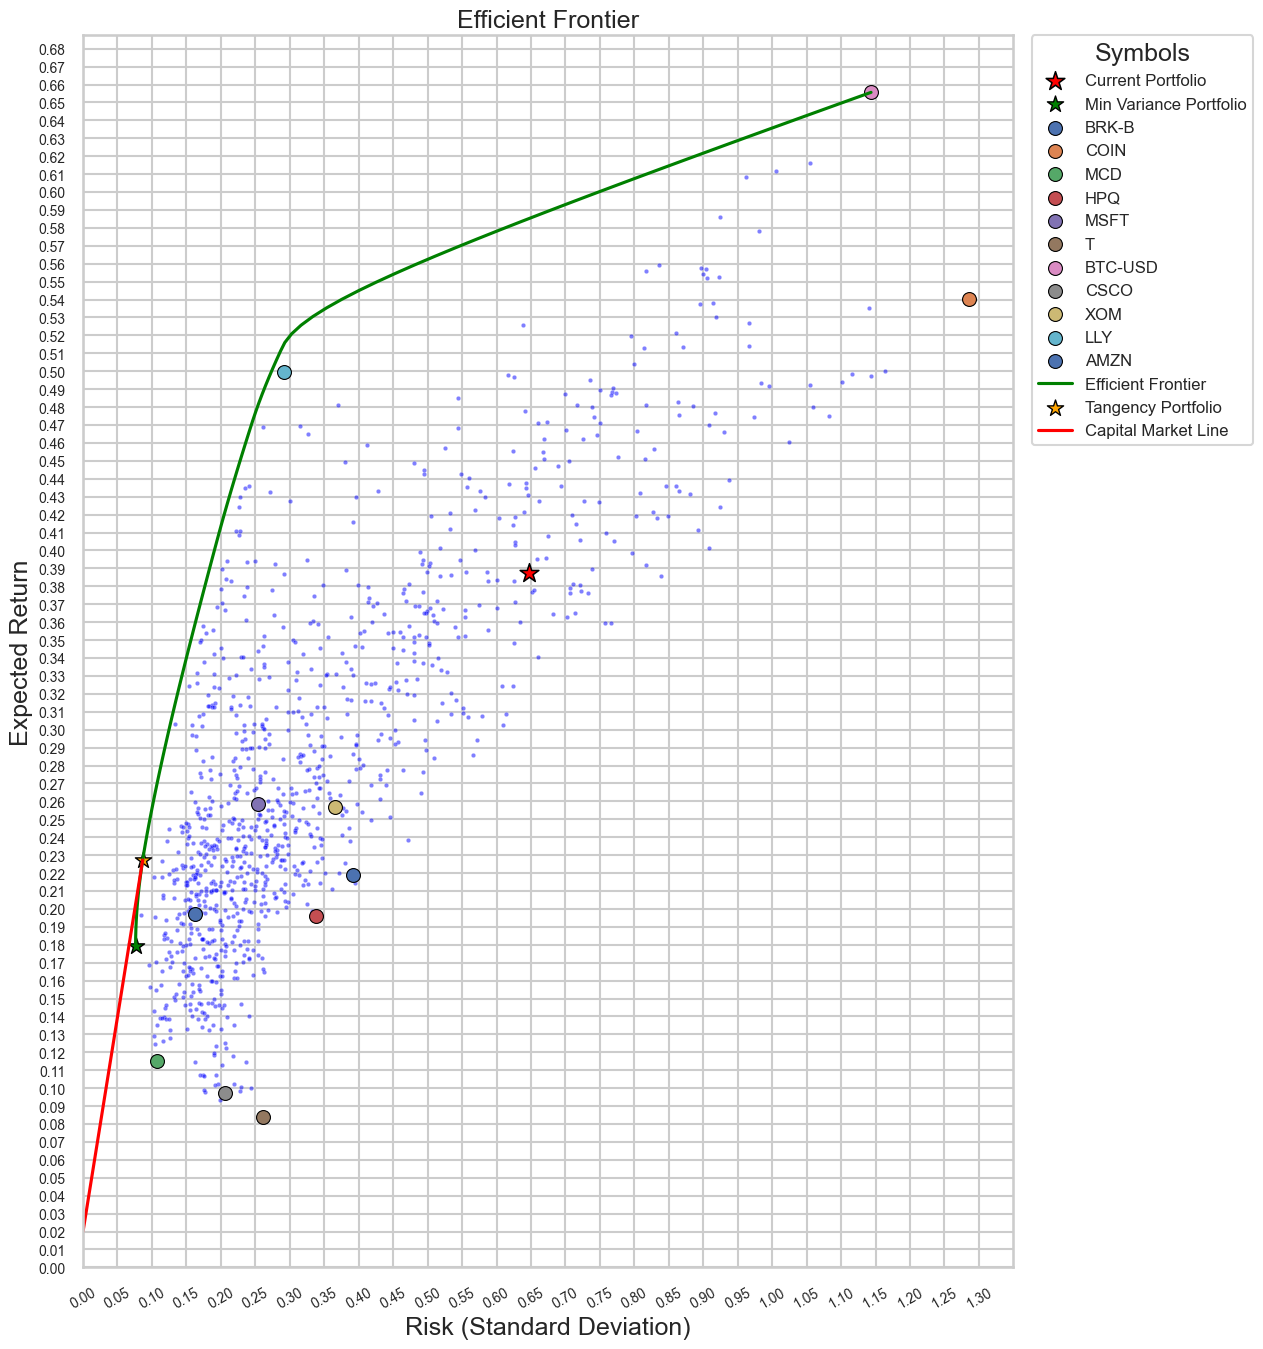

In [6]:
sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(12, 16))

ax = plt.gca()  # Get current axes to customize grid later

# Plot portfolio
w = np.array(pp.weights)
ret = pp.compute_return(w)
risk = pp.compute_risk(w)

sns.scatterplot(
    x=[risk], 
    y=[ret], 
    s=200, 
    color='red', 
    edgecolor='black', 
    marker="*",
    label='Current Portfolio', 
)

# Plot random portfolios
RAN_PORTFOLIOS = 1000
for _ in range(RAN_PORTFOLIOS):
    # Generate random weights
    w = np.random.dirichlet(np.ones(len(symbols)) * 0.2)
    w /= np.sum(w)  # Normalize to sum to 1

    # Calculate portfolio return and risk
    ret = pp.compute_return(w)
    risk = pp.compute_risk(w)

    # Plot the portfolio on the scatter plot
    sns.scatterplot(
        x=[risk],
        y=[ret],
        color="blue",
        s=10,
        alpha=0.5,
    )

# Plot min variance portfolio
min_var_weights = pp.compute_min_var_portfolio()
ret = pp.compute_return(min_var_weights)
risk = pp.compute_risk(min_var_weights)
sns.scatterplot(
    x=[risk], 
    y=[ret], 
    s=150, 
    color='green', 
    edgecolor='black', 
    marker="*",
    label='Min Variance Portfolio', 
)

# Plot individual stocks
for i, symbol in enumerate(symbols):
    ret = pp.mean_returns[i]
    risk = pp.stock_std_risks[i]

    sns.scatterplot(
        x=[risk],
        y=[ret],
        s=100,
        label=symbol,
        edgecolor='black',
        marker="o",
    )

# Plot efficient frontier
efficient_portfolios = pp.compute_efficient_frontier()
efficient_df = pd.DataFrame(efficient_portfolios, columns=['risk', 'return'])
sns.lineplot(
    data=efficient_df,
    x="risk",
    y="return",
    color="green",
    label="Efficient Frontier",
)

# Plot the maximum Sharpe ratio portfolio
risk_free_rate = 0.02  # Example risk-free rate
tangency_portfolio_weights = None
tangency_portfolio_return = 0
tangency_portfolio_risk = 0
sharp_ratio = -np.inf

for portfolio in efficient_portfolios:
    ret = portfolio['return']
    risk = portfolio['risk']
    w = portfolio['weights']
    sr = (ret - risk_free_rate) / risk if risk > 0 else -np.inf

    if sr > sharp_ratio:
        sharp_ratio = sr
        tangency_portfolio_return = ret
        tangency_portfolio_risk = risk
        tangency_portfolio_weights = w

sns.scatterplot(
    x=[tangency_portfolio_risk], 
    y=[tangency_portfolio_return], 
    s=150, 
    color='orange', 
    edgecolor='black', 
    marker="*",
    label='Tangency Portfolio', 
)

# Plot the Capital Market Line
sns.lineplot(
    x=[0, tangency_portfolio_risk],
    y=[risk_free_rate, tangency_portfolio_return],
    color="red",
    label="Capital Market Line",
)

# Add more detailed gridlines
ax.xaxis.set_major_locator(
    ticker.MultipleLocator(0.05)
)  # e.g. grid every 0.05 on x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

# Customize tick labels
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10, rotation=0)

plt.xlim(left=0)  # x-axis (Risk) starts at 0
plt.ylim(bottom=0)  # y-axis (Return) starts at 0

plt.title("Efficient Frontier")
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
# Legend outside plot area
plt.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    fontsize=12,
    title="Symbols",
)
plt.grid(True)
plt.show()


In [7]:
portfolio_return = pp.exp_return
portfolio_risk = pp.exp_risk
print(f"Expected Portfolio Return: {portfolio_return:.2%}")
print(f"Expected Portfolio Risk: {portfolio_risk:.2f}")
target_return = 0.212
target_portfolio = pp.compute_target_return_portfolio(target_return)
target_portfolio_weights = target_portfolio['weights']
target_holdings = pp.weights_to_holdings(target_portfolio_weights)
print(f"Target Portfolio Return: {target_portfolio['return']:.2%}")
print(f"Target Portfolio Risk: {target_portfolio['risk']:.2f}")
print(f"Tangency Portfolio Return: {tangency_portfolio_return:.2%}")
print(f"Tangency Portfolio Risk: {tangency_portfolio_risk:.2f}")

Expected Portfolio Return: 38.74%
Expected Portfolio Risk: 0.65
Target Portfolio Return: 21.20%
Target Portfolio Risk: 0.08
Tangency Portfolio Return: 22.73%
Tangency Portfolio Risk: 0.09


In [8]:
profiles = {
    "current": { # round to 2 decimal places
        symbol: round(weight, 2)
        for symbol, weight in zip(symbols, pp.weights)
    },
    "min_var": {
        symbol: round(weight, 2)
        for symbol, weight in zip(symbols, min_var_weights)
    },
    "tangency": {
        symbol: round(weight, 2)
        for symbol, weight in zip(symbols, tangency_portfolio_weights)
    },
    "target": {
        symbol: round(weight, 2)
        for symbol, weight in zip(symbols, target_portfolio_weights)
    }
}

profiles_df = pd.DataFrame(profiles)
profiles_df.index = symbols
print("Portfolio Weights:")
print(profiles_df)

Portfolio Weights:
         current  min_var  tangency  target
BRK-B       0.17     0.00      0.00    0.00
COIN        0.42     0.00      0.00    0.00
MCD         0.08     0.60      0.47    0.51
HPQ         0.10     0.00      0.00    0.00
MSFT        0.06     0.00      0.00    0.00
T           0.05     0.14      0.13    0.14
BTC-USD     0.12     0.00      0.00    0.00
CSCO        0.00     0.00      0.00    0.00
XOM         0.00     0.05      0.08    0.07
LLY         0.00     0.14      0.26    0.22
AMZN        0.00     0.07      0.06    0.06


In [9]:
min_var_holdings = pp.weights_to_holdings(min_var_weights)
tangency_holdings = pp.weights_to_holdings(tangency_portfolio_weights)

profiles = {
    "current": { # round to 2 decimal places
        symbol: round(holding, 2)
        for symbol, holding in zip(symbols, holdings)
    },
    "min_var": {
        symbol: round(holding, 2)
        for symbol, holding in zip(symbols, min_var_holdings)
    },
    "tangency": {
        symbol: round(holding, 2)
        for symbol, holding in zip(symbols, tangency_holdings)
    },
    "target": {
        symbol: round(holding, 2)
        for symbol, holding in zip(symbols, target_holdings)
    }
}

profiles_df = pd.DataFrame(profiles)
profiles_df.index = symbols
print("Portfolio Holdings:")
print(profiles_df)

Portfolio Holdings:
         current  min_var  tangency  target
BRK-B       9.00     0.00      0.00    0.00
COIN       30.00     0.00      0.00    0.00
MCD         7.00    51.60     40.58   44.10
HPQ       100.00     0.00      0.00    0.00
MSFT        3.00     0.00      0.00    0.00
T          40.00   124.94    116.87  119.42
BTC-USD     0.03     0.00      0.00    0.00
CSCO        0.00     0.00      0.00    0.00
XOM         0.00    10.93     16.66   14.82
LLY         0.00     4.49      8.17    7.00
AMZN        0.00     7.52      7.01    7.16


Portfolio Returns and Max Drawdowns:
      Portfolio   Return Max Drawdown
0       Current   90.48%      -64.76%
1  Min Variance   83.24%      -11.71%
2      Tangency  114.55%      -10.07%
3        Target  104.18%      -10.55%
4           SPY   57.46%      -24.50%


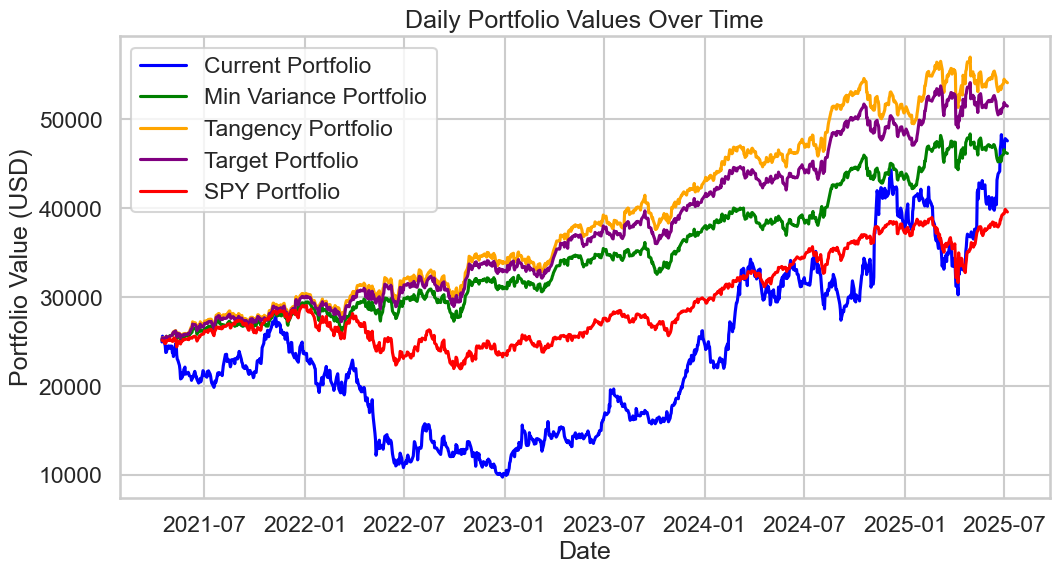

In [10]:
current_values = pp.compute_daily_portfolio_value(pp.weights)
min_var_values = pp.compute_daily_portfolio_value(min_var_weights)
tangency_values = pp.compute_daily_portfolio_value(tangency_portfolio_weights)
target_values = pp.compute_daily_portfolio_value(target_portfolio_weights)

start_date=current_values.index.min().date()
end_date=current_values.index.max().date()
spy = pp.compute_spy_portfolio_value(start_date, end_date)

# Report returns over the period
# current portfolio return
d = current_values.index[-1] - current_values.index[0]
current_return = (current_values.iloc[-1] - current_values.iloc[0]) / current_values.iloc[0]
min_var_return = (min_var_values.iloc[-1] - min_var_values.iloc[0]) / min_var_values.iloc[0]
tangency_return = (tangency_values.iloc[-1] - tangency_values.iloc[0]) / tangency_values.iloc[0]
target_return = (target_values.iloc[-1] - target_values.iloc[0]) / target_values.iloc[0]
spy_return = (spy.iloc[-1] - spy.iloc[0]) / spy.iloc[0]

# Report the max drawdown for each portfolio
def max_drawdown(series: pd.Series) -> float:
    """Calculate the maximum drawdown of a time series."""
    df = series.to_frame(name='values')
    df['peak'] = df['values'].cummax()
    df['drawdown'] = (df['values'] - df['peak']) / df['peak']
    return df['drawdown'].min()

current_drawdown = max_drawdown(current_values)
min_var_drawdown = max_drawdown(min_var_values)
tangency_drawdown = max_drawdown(tangency_values)
target_drawdown = max_drawdown(target_values)
spy_drawdown = max_drawdown(spy)

df = pd.DataFrame({
    "Portfolio": ["Current", "Min Variance", "Tangency", "Target","SPY"],
    "Return": [current_return, min_var_return, tangency_return, target_return, spy_return],
    "Max Drawdown": [current_drawdown, min_var_drawdown, tangency_drawdown, target_drawdown, spy_drawdown]
})

# Format columns as percentage strings
df["Return"] = df["Return"].map(lambda x: f"{x:.2%}")
df["Max Drawdown"] = df["Max Drawdown"].map(lambda x: f"{x:.2%}")

print("Portfolio Returns and Max Drawdowns:")
print(df)

plt.figure(figsize=(12, 6))
plt.plot(current_values, label="Current Portfolio", color='blue')
plt.plot(min_var_values, label="Min Variance Portfolio", color='green')
plt.plot(tangency_values, label="Tangency Portfolio", color='orange')
plt.plot(target_values, label="Target Portfolio", color='purple')
plt.plot(spy, label="SPY Portfolio", color='red')
plt.title("Daily Portfolio Values Over Time")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.show()

The t-stat tells you how likely it is that a result (like alpha or Sharpe ratio) happened by chance.

| t-stat | Interpretation                  |
| ------ | ------------------------------- |
| < 1.5  | Not significant                 |
| 1.5–2  | Possibly significant            |
| > 2    | Statistically significant       |
| > 3    | Strong statistical significance |


In [11]:
min_var_t_stats = pp.compute_t_stats(min_var_weights)
tangency_portfolio_t_stats = pp.compute_t_stats(tangency_portfolio_weights)
target_portfolio_t_stats = pp.compute_t_stats(target_portfolio_weights)


profiles = {
    "min_var": min_var_t_stats,
    "tangency": tangency_portfolio_t_stats,
    "target": target_portfolio_t_stats
}

profiles_df = pd.DataFrame(profiles)
print("Portfolio T Stats:")
print(profiles_df)

Portfolio T Stats:
              min_var  tangency    target
mean_return  0.000618  0.000770  0.000722
std          0.009167  0.009404  0.009260
t_stat       2.196699  2.667451  2.539011


## PCA for Portfolio Analysis
PCA (Principal Component Analysis) is a powerful tool for analyzing correlation structures in a portfolio. It helps uncover how many unique sources of risk or diversification exist among your assets.

### What is PCA in the Context of Correlation Matrices?
PCA decomposes your correlation matrix into orthogonal components (directions) that explain the variance in the system. These are called principal components (PCs).

For a correlation matrix:
- First principal component = direction of maximum shared movement.
- Subsequent components = uncorrelated patterns of variation.
- The explained variance ratio tells you how much of the total market movement is explained by each component.

## 🧮 Mathematically

Given a correlation matrix $\mathbf{C}$, PCA finds eigenvalues $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n$ and eigenvectors $v_1, v_2, \dots, v_n$ such that:

\begin{equation}
\mathbf{C} v_i = \lambda_i v_i
\end{equation}

Where:

- $\lambda_i $ tells you **how much variance** is explained by the $i^\text{th}$ component.
- Total variance = sum of all $ \lambda_i $ = number of assets (if using a correlation matrix).


In [12]:
# Apply PCA on correlation matrix
pca = PCA()
pca.fit(pp.compute_cor_matrix())

# Explained variance ratios
explained = pca.explained_variance_ratio_

# Print top components
for i, var in enumerate(explained[:5]):
    print(f"PC{i+1}: {var:.2%} of variance")

PC1: 60.66% of variance
PC2: 17.74% of variance
PC3: 11.78% of variance
PC4: 5.12% of variance
PC5: 2.98% of variance


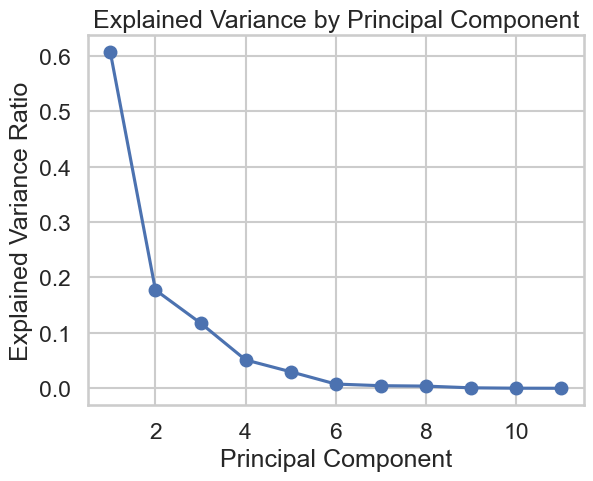

In [13]:
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

| Metric            | Meaning                                                |
| ----------------- | ------------------------------------------------------ |
| **PC1 \~ 70–90%** | Most assets are moving together. Poor diversification. |
| **PC1 \~ 40–60%** | Some dominant trend, but some diversification.         |
| **PC1 < 30%**     | Well diversified — many independent sources of return. |


- PC1 might represent "market risk" — the movement of all stocks together.

- PC2/PC3 might represent sector risks (e.g., tech vs. consumer).